In [1]:
!pip install torchaudio==0.7.0
!pip install librosa==0.8.0
!pip install git+https://github.com/indrasweb/chvoice

     |████████████████████████████████| 7.6MB 6.9MB/s 
     |████████████████████████████████| 184kB 8.9MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201375 sha256=59521781c6553d27fc595dcc5b955b132023190fe783925896e38714d9304c50
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
  Cloning https://github.com/indrasweb/chvoice to /tmp/pip-req-build-nutmd_hg
  Running command git clone -q https://github.com/indrasweb/chvoice /tmp/pip-req-build-nutmd_hg
  Created wheel for chvoice: filename=chvoice-0.0.1-cp36-none-any.whl size=5071 sha256=64bf0758f5cfdbf68fad754b44296fd25811c12d08d3c931078aff08a39ba80b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5nl1__ke/wheels/87/5a/6b/0a763689bb1840664ecf12800

In [2]:
import torch as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchvision
import numpy as np
from torchsummary import torchsummary
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import os
from glob import glob
import operator
from google.colab import drive
from torch.autograd import Variable
import chvoice
import pickle
import pandas as pd
import seaborn as sns

sns.set()
sns.color_palette("viridis", as_cmap=True)
sns.set_style("whitegrid", {'axes.grid' : False})

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

# Experiment Configuration

In [5]:
experiment_save_path = pth = 'drive/MyDrive/chvoice-experiments-kd5/'

if not os.path.exists(experiment_save_path):
    os.mkdir(experiment_save_path)

wav_noise_config = {
    './noises/keyboard-mono': {'prob': 0.4, 'mul': 0.3},
    './noises/coughing-mono': {'prob': 0.1, 'mul': .1},
    './noises/clock-tick-mono': {'prob': 0.1, 'mul': .3},
    './noises/click-mono': {'prob': 0.2, 'mul': .3},
    './noises/wind-mono': {'prob': 0.2, 'mul': .1}
}

additional_noise_config = {
    'white_noise': {'prob': 0.1, 'mul': 0.3},
    'no_noise': {'prob': 0.1},
    'reverb': {'prob': 0.1, 'density': 15}
}


Get Librispeech dataset, and some noise 

In [6]:
#train_dataset = ta.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
train_dataset = ta.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [7]:
!curl -L -o noises.zip https://github.com/indrasweb/chvoice/raw/main/noises.zip
!unzip -q noises.zip
!rm -rf noises/.DS_Store

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0    665      0 --:--:-- --:--:-- --:--:--   665
100 15.7M  100 15.7M    0     0  14.3M      0  0:00:01  0:00:01 --:--:-- 44.3M


In [8]:
def preprocess(X, dsp, noiser):
    clean = []
    noisy = []
    wavs = [d[0] for d in X]

    for wav in wavs:

        db, phase = dsp.sig_to_db_phase(wav)
        if db.size(2) < 128:
            continue

        # make clean chunks of audio
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        clean.append(chunks)

        # make corresponding noisy chunks of audio
        aug_wav = noiser.add_noise(wav.squeeze(0))
        db, phase = dsp.sig_to_db_phase(aug_wav.unsqueeze(0))
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        noisy.append(chunks)

    clean = T.vstack(clean).unsqueeze(1)
    noisy = T.vstack(noisy).unsqueeze(1)
    
    return clean, noisy

## Model Definition (UNet)

In [9]:
class PrunableConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.taylor_estimates = None
        self._recent_activations = None
        self._pruning_hook = None

    def forward(self, x):
        output = super().forward(x)
        self._recent_activations = output.clone()
        return output

    def set_pruning_hooks(self):
        self._pruning_hook = self.register_backward_hook(self._calculate_taylor_estimate)

    def _calculate_taylor_estimate(self, _, grad_input, grad_output):
        # skip dim 1 as it is kernel size
        estimates = self._recent_activations.mul_(grad_output[0])
        estimates = estimates.mean(dim=(0, 2, 3))        

        # normalization
        self.taylor_estimates = T.abs(estimates) / T.sqrt(T.sum(estimates * estimates))
        del estimates, self._recent_activations
        self._recent_activations = None

    def prune_feature_map(self, map_index):
        is_cuda = self.weight.is_cuda

        indices = Variable(T.LongTensor([i for i in range(self.out_channels) if i != map_index]))
        indices = indices.cuda() if is_cuda else indices

        self.weight = nn.Parameter(self.weight.index_select(0, indices).data)
        self.bias = nn.Parameter(self.bias.index_select(0, indices).data)
        self.out_channels -= 1

    def drop_input_channel(self, index):
        is_cuda = self.weight.is_cuda

        indices = Variable(torch.LongTensor([i for i in range(self.in_channels) if i != index]))
        indices = indices.cuda() if is_cuda else indices

        self.weight = nn.Parameter(self.weight.index_select(1, indices).data)
        self.in_channels -= 1

class PrunableBatchNorm2d(nn.BatchNorm2d):
  def __init__(self, channels):
      super(PrunableBatchNorm2d, self).__init__(channels)

  def drop_input_channel(self, index):
        if self.affine:
            is_cuda = self.weight.is_cuda
            indices = Variable(torch.LongTensor([i for i in range(self.num_features) if i != index]))
            indices = indices.cuda() if is_cuda else indices

            self.weight = nn.Parameter(self.weight.index_select(0, indices).data)
            self.bias = nn.Parameter(self.bias.index_select(0, indices).data)
            self.running_mean = self.running_mean.index_select(0, indices.data)
            self.running_var = self.running_var.index_select(0, indices.data)

        self.num_features -= 1

      
  
  def forward(self, x):
      x = super().forward(x)
      return x
      


In [10]:
class p_double_conv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_channels=None):
        super(p_double_conv, self).__init__()
        
        if not mid_channels:
            mid_channels = out_ch

        self.quant1 = T.quantization.QuantStub()
        self.dequant1 = T.quantization.DeQuantStub()

        self.conv = nn.Sequential(
            PrunableConv2d(in_ch, out_ch, 3, padding=1),
            PrunableBatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            PrunableConv2d(mid_channels, out_ch, 3, padding=1),
            PrunableBatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        


    def forward(self, x):
        x = self.quant1(x)
        x = self.conv(x)
        x = self.dequant1(x)
        return x


class p_inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(p_inconv, self).__init__()
        self.conv = p_double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class p_down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(p_down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            p_double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class p_up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(p_up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = p_double_conv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch , in_ch // 2, kernel_size=2, stride=2)
            self.conv = p_double_conv(in_ch, out_ch)
        

      

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = T.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class p_outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(p_outconv, self).__init__()
        self.conv = PrunableConv2d(in_ch, out_ch, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = self.conv(x)
        return x


In [20]:
class PruneUNet(nn.Module):
    def __init__(self, n_channels, n_classes, channel_depth=64):
        super(PruneUNet, self).__init__()
        self.inc = p_inconv(n_channels, channel_depth)
        self.down1 = p_down(channel_depth, (channel_depth*2))
        self.down2 = p_down((channel_depth*2), (channel_depth*4))
        self.down3 = p_down((channel_depth*4), (channel_depth*8))
        self.down4 = p_down((channel_depth*8), (channel_depth*8))
        self.up1 = p_up(channel_depth*16, (channel_depth*4))
        self.up2 = p_up(channel_depth*8, (channel_depth*2))
        self.up3 = p_up(channel_depth*4, channel_depth)
        self.up4 = p_up(channel_depth*2, channel_depth)
        self.outc = p_outconv(channel_depth, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

    def set_pruning(self):
        prunable_modules = [module for module in self.modules()
                             if getattr(module, "prune_feature_map", False)
                             and module.out_channels > 1]

        # # Print getting all conv layers
        # for i, m in enumerate(self.modules()):
        #     if getattr(m, "prune_feature_map", False) and m.out_channels > 1:
        #         print(i, "->", m)

        for p in prunable_modules:
            p.set_pruning_hooks()
    
    def prune(self, verbose=False):
        # Get all layers excluding larger blocks
        module_list = [module for module in self.modules() 
                        if not isinstance(module, 
                            (nn.Sequential, 
                            p_double_conv, 
                            p_inconv, 
                            p_down, 
                            p_up, 
                            p_outconv,
                            PruneUNet)
                            )
                        ]
        
        # Also checks if layer has been pruned to 1 channel remaining
        taylor_estimates_by_module = [(module.taylor_estimates, idx) for idx, module in enumerate(module_list) if getattr(module, "prune_feature_map", False) and module.out_channels > 1]
        taylor_estimates_by_feature_map = [(estimate, f_map_idx, module_idx) for estimates_by_f_map, module_idx in taylor_estimates_by_module for f_map_idx, estimate in enumerate(estimates_by_f_map)]

        min_estimate, min_f_map_idx, min_module_idx = min(taylor_estimates_by_feature_map, key=operator.itemgetter(0))

        p_conv = module_list[min_module_idx]
        p_conv.prune_feature_map(min_f_map_idx)
        
        if verbose:
            print("Pruned conv layer number {}, {}".format(min_module_idx, p_conv))

        # Find next conv layer to drop input channel
        is_last_conv = len(module_list)-1 == min_module_idx
        if not is_last_conv:
            p_batchnorm = module_list[min_module_idx+1]
            p_batchnorm.drop_input_channel(min_f_map_idx)
            
            next_conv_idx = min_module_idx + 2
            while next_conv_idx < len(module_list):
                if isinstance(module_list[next_conv_idx], PrunableConv2d):
                    module_list[next_conv_idx].drop_input_channel(min_f_map_idx)
                    if verbose:
                        print("Found next conv layer at number {}, {}"
                            .format(next_conv_idx, module_list[next_conv_idx]))
                    break
                next_conv_idx += 1
            
            # Hardcoded way of dealing with up sampled layers

            # x4 as output of down3 -> drop input channel of up1
            if min_module_idx == 24:
                p_up_conv = module_list[35]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x3 as output of down2 -> drop input channel of up2
            elif min_module_idx == 17:
                p_up_conv = module_list[42]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x2 as output of down1 -> drop input channel of up3
            elif min_module_idx == 10:
                p_up_conv = module_list[49]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x1 as output of inc -> drop input channel of up4
            elif min_module_idx == 3:
                p_up_conv = module_list[56]
                p_up_conv.drop_input_channel(min_f_map_idx)


In [12]:
class PruneUNet(nn.Module):
    def __init__(self, n_channels, n_classes, channel_depth=64):
        super(PruneUNet, self).__init__()
        self.inc = p_inconv(n_channels, channel_depth)
        self.down1 = p_down(channel_depth, (channel_depth*2))
        self.down2 = p_down((channel_depth*2), (channel_depth*4))
        self.down3 = p_down((channel_depth*4), (channel_depth*4))
        self.up2 = p_up(channel_depth*8, (channel_depth*2))
        self.up3 = p_up(channel_depth*4, channel_depth)
        self.up4 = p_up(channel_depth*2, channel_depth)
        self.outc = p_outconv(channel_depth, n_classes)
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

    def set_pruning(self):
        prunable_modules = [module for module in self.modules()
                             if getattr(module, "prune_feature_map", False)
                             and module.out_channels > 1]

        # # Print getting all conv layers
        # for i, m in enumerate(self.modules()):
        #     if getattr(m, "prune_feature_map", False) and m.out_channels > 1:
        #         print(i, "->", m)

        for p in prunable_modules:
            p.set_pruning_hooks()
    
    def prune(self, verbose=False):
        # Get all layers excluding larger blocks
        module_list = [module for module in self.modules() 
                        if not isinstance(module, 
                            (nn.Sequential, 
                            p_double_conv, 
                            p_inconv, 
                            p_down, 
                            p_up, 
                            p_outconv,
                            PruneUNet)
                            )
                        ]
        
        # Also checks if layer has been pruned to 1 channel remaining
        taylor_estimates_by_module = [(module.taylor_estimates, idx) for idx, module in enumerate(module_list) if getattr(module, "prune_feature_map", False) and module.out_channels > 1]
        taylor_estimates_by_feature_map = [(estimate, f_map_idx, module_idx) for estimates_by_f_map, module_idx in taylor_estimates_by_module for f_map_idx, estimate in enumerate(estimates_by_f_map)]

        min_estimate, min_f_map_idx, min_module_idx = min(taylor_estimates_by_feature_map, key=operator.itemgetter(0))

        p_conv = module_list[min_module_idx]
        p_conv.prune_feature_map(min_f_map_idx)
        
        if verbose:
            print("Pruned conv layer number {}, {}".format(min_module_idx, p_conv))

        # Find next conv layer to drop input channel
        is_last_conv = len(module_list)-1 == min_module_idx
        if not is_last_conv:
            p_batchnorm = module_list[min_module_idx+1]
            p_batchnorm.drop_input_channel(min_f_map_idx)
            
            next_conv_idx = min_module_idx + 2
            while next_conv_idx < len(module_list):
                if isinstance(module_list[next_conv_idx], PrunableConv2d):
                    module_list[next_conv_idx].drop_input_channel(min_f_map_idx)
                    if verbose:
                        print("Found next conv layer at number {}, {}"
                            .format(next_conv_idx, module_list[next_conv_idx]))
                    break
                next_conv_idx += 1
            
            # Hardcoded way of dealing with up sampled layers

            # x4 as output of down3 -> drop input channel of up1
            if min_module_idx == 24:
                p_up_conv = module_list[35]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x3 as output of down2 -> drop input channel of up2
            elif min_module_idx == 17:
                p_up_conv = module_list[42]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x2 as output of down1 -> drop input channel of up3
            elif min_module_idx == 10:
                p_up_conv = module_list[49]
                p_up_conv.drop_input_channel(min_f_map_idx)
            # x1 as output of inc -> drop input channel of up4
            elif min_module_idx == 3:
                p_up_conv = module_list[56]
                p_up_conv.drop_input_channel(min_f_map_idx)


# Evaluation

In [13]:
def evaluate(noisy_sig, clean_sig, model, plot_spectrograms=False):
    model.eval()
    
    db, phase = dsp.sig_to_db_phase(noisy_sig)
    if(db.size(2) < 128):
      return -1
    #assert db.size(2) >= 128, 'wav too small'
    db_clean, _ = dsp.sig_to_db_phase(clean_sig)

    if plot_spectrograms:
        print('input dB spectrogram (noisy)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db[0])
        plt.show()

        print('target dB spectogram (clean)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db_clean[0])
        plt.show()

    chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
    mean = T.mean(chunks)
    std = T.std(chunks) + 1e-6
    chunks = (chunks - mean) / std  # normalize
    chunks = chunks.unsqueeze(1).to(DEVICE)
                 
    with T.no_grad():
        proc = model(chunks)
    
    proc = (proc * std) + mean  # denormalize
    db_out = T.cat([c for c in proc.squeeze(1)], dim=1).cpu()
    
    if plot_spectrograms:
        print('db spectrogram (prediction)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(db_out.numpy())
        plt.show()
    
    phase_clipped = phase[0,:,:db_out.size(1)]
    sig = dsp.db_phase_to_sig(db_out, phase_clipped)

    diff = db_out.numpy() - db[0].numpy()[:, :db_out.size(1)]
    if plot_spectrograms:
        print('noisy - prediciton (difference)')
        fig, ax = plt.subplots(figsize=(12,4))
        ax.imshow(diff)
        plt.show()
    
    return np.sqrt(np.mean(diff*diff))

In [14]:
test_dataset = ta.datasets.LIBRISPEECH("./", url="test-clean", download=True)
noiser = chvoice.Noiser(wav_noise_config, additional_noise_config)
dsp = chvoice.DSP()

test_loader = T.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

In [15]:
evaluation_in_sig = train_dataset[100][0]
Audio(evaluation_in_sig, rate=16000)

In [16]:
evaluation_wobbly = noiser.add_noise(evaluation_in_sig.squeeze(0)).unsqueeze(0)
Audio(evaluation_wobbly, rate=16000)


In [17]:
reverber = chvoice.ReverbEcho(repeat=15)
evaluation_sig_reverb = reverber.reverb(evaluation_in_sig.unsqueeze(0)).squeeze(0)
Audio(evaluation_sig_reverb, rate=16000)

In [18]:
def evaluate_whole_test_set(model):
    avg_rms = 0
    c = 200
    counter = 0
    crit = nn.MSELoss()
    for i, clean in enumerate(test_dataset):
        #print(clean)
        noisy = noiser.add_noise(clean[0].squeeze(0)).unsqueeze(0)
        x = evaluate(noisy, clean[0], model, plot_spectrograms=False)
        if(x != -1):
          avg_rms += x
          counter += 1
        if counter == c: break
    return avg_rms/c

## Train

In [19]:
train_loader = T.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

## No Pruning

In [ ]:
model = PruneUNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()
loss_history = []

for epoch in range(0, 5):
    print(f'----- EPOCH {epoch} -----')
    for i, (clean, noisy) in enumerate(train_loader):
        clean = clean[:64,:,:,:].to(DEVICE)
        noisy = noisy[:64,:,:,:].to(DEVICE)
        # normalize
        mean = T.mean(noisy)
        std = T.std(noisy)
        noisy = (noisy - mean) / (std + 1e-6)
        optim.zero_grad()
        pred = model(noisy)
        # denormlaize
        pred = (pred * (std + 1e-6)) + mean
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        if not i%10:
          print(f'E{epoch}:{i}\tLoss {loss.item():.4f}')
    
    with open(pth+'loss-history-no-pruning.pkl', 'wb') as f:
        pickle.dump(loss_history, f)
    T.save(model.state_dict(), pth+f'model-no-pruning-{epoch}.pkl')

----- EPOCH 0 -----


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


E0:0	Loss 455.0069
E0:10	Loss 98.0499
E0:20	Loss 18.9567


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(loss_history).rolling(250).mean()
df.plot()

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_wobbly, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_sig_reverb, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
test_loss = evaluate_whole_test_set(model)
print(f'Test MSE {test_loss}')

## With Pruning

In [ ]:
model = PruneUNet(n_channels=1, n_classes=1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()
loss_history = []
model.set_pruning()
counter = 0

for epoch in range(1, 5):
    print(f'----- EPOCH {epoch} -----')
    for i, (clean, noisy) in enumerate(train_loader):
        clean = clean[:64,:,:,:].to(DEVICE)
        noisy = noisy[:64,:,:,:].to(DEVICE)
        # normalize
        mean = T.mean(noisy)
        std = T.std(noisy)
        noisy = (noisy - mean) / (std + 1e-6)
        optim.zero_grad()

        try:
            pred = model(noisy)
        except:
            print("Pruning broke something")
            counter += 1
            model = T.load(pth+f'raw_model')
            pred = model(noisy)

        # denormlaize
        pred = (pred * (std + 1e-6)) + mean
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        loss_history.append(loss.item())

        if not i%10:
            print(f'E{epoch}:{i}\tLoss {loss.item():.4f}')

    T.save(model, pth+f'raw_model')
    
    for j in range(30):
        model.prune(verbose=True) 
        
    with open(pth+'loss-history-with-pruning.pkl', 'wb') as f:
        pickle.dump(loss_history, f)
    T.save(model.state_dict(), pth+f'model-with-pruning-{epoch}.pkl')

print("Pruning failed: " + str(counter))

----- EPOCH 1 -----


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


E1:0	Loss 74.4338
E1:10	Loss 227.8901
E1:20	Loss 15.9352
E1:30	Loss 28.6848
E1:40	Loss 42.3281
E1:50	Loss 20.0882
E1:60	Loss 36.5353
E1:70	Loss 36.2313
E1:80	Loss 19.0719
E1:90	Loss 25.1662
E1:100	Loss 232.1343
E1:110	Loss 92.9599
E1:120	Loss 26.2489
E1:130	Loss 27.9842
E1:140	Loss 62.3737
E1:150	Loss 221.6167
E1:160	Loss 8.7156
E1:170	Loss 13.1541
E1:180	Loss 67.7973
E1:190	Loss 9.0868
E1:200	Loss 33.1393
E1:210	Loss 36.5235
E1:220	Loss 27.5585
E1:230	Loss 17.1350
E1:240	Loss 79.8577
E1:250	Loss 195.8305
E1:260	Loss 8.9814
E1:270	Loss 160.6657
E1:280	Loss 13.2974
E1:290	Loss 17.6676
E1:300	Loss 4.8588
E1:310	Loss 32.5264
E1:320	Loss 16.4166
E1:330	Loss 5.1382
E1:340	Loss 23.6864
E1:350	Loss 5.7161
E1:360	Loss 25.4545
E1:370	Loss 84.8556
E1:380	Loss 6.3295
E1:390	Loss 29.1434
E1:400	Loss 6.7129
E1:410	Loss 45.4953
E1:420	Loss 9.6131
E1:430	Loss 10.8249
E1:440	Loss 9.8598
E1:450	Loss 38.9332
E1:460	Loss 32.7305
E1:470	Loss 39.4330
E1:480	Loss 38.1242
E1:490	Loss 22.1974
E1:500	Loss 64.1

RuntimeError: ignored

In [ ]:
df = pd.DataFrame(loss_history).rolling(250).mean()
df.plot()

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_wobbly, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_sig_reverb, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
test_loss = evaluate_whole_test_set(model)
print(f'Test MSE {test_loss}')

## Knowledge Distillation

In [ ]:
model = PruneUNet(n_channels=1, n_classes=1).to(DEVICE).eval()
model.load_state_dict(T.load('./model.pkl'))
student = PruneUNet(n_channels=1, n_classes=1, channel_depth=32).to(DEVICE)
student.load_state_dict(T.load('./model-prev.pkl'))

optim = T.optim.Adam(student.parameters(), 4e-4)
crit = nn.MSELoss()
loss_history = []


for epoch in range(4, 5):
    print(f'----- EPOCH {epoch} -----')

    for i, (clean, noisy) in enumerate(train_loader):
        # clean = clean[:64,:,:,:].to(DEVICE) # Don't need!
        noisy = noisy[:64,:,:,:].to(DEVICE)

        mean = T.mean(noisy)
        std = T.std(noisy)
        noisy = (noisy - mean) / (std + 1e-6)

        model_output = model(noisy)
        # denormlaize
        model_output = (model_output * (std + 1e-6)) + mean

        optim.zero_grad()
        pred = student(noisy)
        pred = (pred * (std + 1e-6)) + mean

        loss = crit(pred, model_output)
        loss.backward()
        optim.step()

        if not i%10:
            print(f'E{epoch}:{i}\tLoss {loss.item():.4f}')

    with open(pth+'loss-history-distillation.pkl', 'wb') as f:
        pickle.dump(loss_history, f)
    T.save(student.state_dict(), pth+f'model-distilled-{epoch}.pkl')

----- EPOCH 4 -----


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


E4:0	Loss 2.7946
E4:10	Loss 2.5973
E4:20	Loss 1.8781
E4:30	Loss 6.5487
E4:40	Loss 1.7593
E4:50	Loss 1.2132
E4:60	Loss 1.3404
E4:70	Loss 1.6069
E4:80	Loss 1.1546
E4:90	Loss 3.0782
E4:100	Loss 1.7884
E4:110	Loss 3.2156
E4:120	Loss 1.8549
E4:130	Loss 1.2199
E4:140	Loss 1.4310
E4:150	Loss 1.3793
E4:160	Loss 1.2210
E4:170	Loss 0.9541
E4:180	Loss 1.7270
E4:190	Loss 38.8111
E4:200	Loss 1.2099
E4:210	Loss 1.5987
E4:220	Loss 3.0818
E4:230	Loss 2.5450
E4:240	Loss 5.9435
E4:250	Loss 1.4731
E4:260	Loss 1.3145
E4:270	Loss 1.9424
E4:280	Loss 1.4706
E4:290	Loss 1.9483
E4:300	Loss 3.0212
E4:310	Loss 2.4345
E4:320	Loss 2.1480
E4:330	Loss 2.0198
E4:340	Loss 17.5170
E4:350	Loss 3.1080
E4:360	Loss 3.4196
E4:370	Loss 1.4588
E4:380	Loss 0.9599
E4:390	Loss 3.5353
E4:400	Loss 2.9048
E4:410	Loss 2.7114
E4:420	Loss 1.8768
E4:430	Loss 2.9421
E4:440	Loss 1.1124
E4:450	Loss 1.7708
E4:460	Loss 1.2741
E4:470	Loss 1.2697
E4:480	Loss 1.4501
E4:490	Loss 1.2259
E4:500	Loss 1.5481
E4:510	Loss 1.8505
E4:520	Loss 0.9994
E4

In [ ]:
df = pd.DataFrame(loss_history).rolling(250).mean()
df.plot()

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_wobbly, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
model = model.eval()
evaluated_sig = evaluate(evaluation_sig_reverb, evaluation_in_sig, model)
Audio(evaluated_sig, rate=16000)

In [ ]:
test_loss = evaluate_whole_test_set(model)
print(f'Test MSE {test_loss}')

# Evaluate the models

In [21]:
wav_noise_config = {
    './noises/keyboard-mono': {'prob': 0.4, 'mul': 0.3},
    './noises/coughing-mono': {'prob': 0.1, 'mul': .1},
    './noises/clock-tick-mono': {'prob': 0.1, 'mul': .3},
    './noises/click-mono': {'prob': 0.2, 'mul': .3},
    './noises/wind-mono': {'prob': 0.2, 'mul': .1}
}

additional_noise_config = {
    'white_noise': {'prob': 0.1, 'mul': 0.3},
    'no_noise': {'prob': 0.1},
    'reverb': {'prob': 0, 'density': 15}
}

noiser = chvoice.Noiser(wav_noise_config, additional_noise_config)

In [22]:
model = PruneUNet(n_channels=1, n_classes=1).to(DEVICE)
#model = PruneUNet(n_channels=1, n_classes=1, channel_depth=32).to(DEVICE)
model.load_state_dict(T.load('drive/MyDrive/L46 Completed Models/model-no-pruning-original-normal-model.pkl'))
#model = T.load('drive/MyDrive/L46 Completed Models/model-no-pruning-original-normal-model.zip')
"""model = T.quantization.quantize_dynamic(
    model,
    {PrunableConv2d, T.nn.ReLU, PrunableBatchNorm2d, T.nn.MaxPool2d, T.nn.Sequential},
    dtype=T.qint8,
    inplace=True
)"""

optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()

evaluation_in_sig = train_dataset[100][0]
evaluation_wobbly = noiser.add_noise(evaluation_in_sig.squeeze(0)).unsqueeze(0)
reverber = chvoice.ReverbEcho(repeat=15)
evaluation_sig_reverb = reverber.reverb(evaluation_in_sig.unsqueeze(0)).squeeze(0)

evaluate(evaluation_wobbly, evaluation_in_sig, model)



RuntimeError: ignored

Text(0.5, 0, 'Training Iteration')

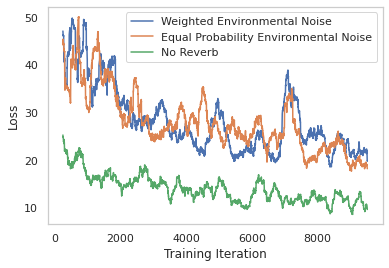

In [ ]:
with open('drive/MyDrive/L46 Completed Models/loss-history-no-pruning-original-normal-model.pkl', 'rb') as f:
  loss_history1 = pickle.load(f)

with open('drive/MyDrive/L46 Completed Models/loss-history-no-pruning-equalprob-normal-model.pkl', 'rb') as f:
  loss_history2 = pickle.load(f)

with open('drive/MyDrive/L46 Completed Models/loss-history-no-pruning-noreverb-normal-model.pkl', 'rb') as f:
  loss_history3 = pickle.load(f)

df = pd.DataFrame(loss_history1, columns=['Weighted Environmental Noise']).rolling(250).mean()
df2 = pd.DataFrame(loss_history2, columns=['Equal Probability Environmental Noise']).rolling(250).mean()
df3 = pd.DataFrame(loss_history3, columns=['No Reverb']).rolling(250).mean()
ax = df.plot(label='Weighted Environmental Noise')
df2.plot(ax=ax, label='Equal Probability Environmental Noise')
df3.plot(ax=ax, label='No Reverb')
ax.set_ylabel("Loss")
ax.set_xlabel("Training Iteration")

In [ ]:
test_loss = evaluate_whole_test_set(model.to(DEVICE))
print(f'Test MSE {test_loss}')

Test MSE 2.965585885643959


In [ ]:
for i, (clean, noisy) in enumerate(train_loader):
  noisy = noisy[:64,:,:,:].to(DEVICE)
  break
  
model.eval()
%timeit model(noisy)

10 loops, best of 3: 204 ms per loop


#Quantize Model

In [ ]:
# DYNAMIC QUANTIZATION - working but not very effective
model = PruneUNet(n_channels=1, n_classes=1).to(DEVICE)
model.load_state_dict(T.load(pth+f'model-no-pruning-4.pkl'))

quantized_model = T.quantization.quantize_dynamic(
    model,
    {PrunableConv2d, T.nn.ReLU, PrunableBatchNorm2d, T.nn.MaxPool2d, T.nn.Sequential},
    dtype=T.qint8,
    inplace=True
)

T.save(quantized_model.state_dict(), pth+f'pruned-model-quantized-4.pkl')

%timeit quantized_model(noisy)
%timeit model(noisy)

In [ ]:
test_loss = evaluate_whole_test_set(quantized_model)
print(f'Test MSE {test_loss}')